### Load Dependencies

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("..")
from ecg_dataset import ECGDataset

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


### Load Dataset

In [2]:
dataset = ECGDataset("../data/preprocessed_beats.npy")
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Define Transformer Architecture

In [3]:
class PositionalEncodingLearnable(nn.Module):
    def __init__(self, d_model, max_len=360):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.empty(1, max_len, d_model))
        nn.init.normal_(self.pos_embedding, std=0.02)

    def forward(self, x):
        return x + self.pos_embedding

class TransformerDecoderOnly(nn.Module):
    def __init__(self, input_len=360, d_model=128, nhead=4, num_layers=4, dropout=0.1):
        super().__init__()
        self.input_len = input_len
        self.d_model = d_model

        self.input_proj = nn.Linear(1, d_model)
        self.pos_encoding = PositionalEncodingLearnable(d_model, max_len=input_len)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [B, 360, 1]
        x_embed = self.input_proj(x)                  # [B, 360, d_model]
        x_embed = self.pos_encoding(x_embed)          # [B, 360, d_model]

        # Create dummy memory input: a zero tensor [B, 1, d_model]
        B = x.size(0)
        memory = torch.zeros(B, 1, self.d_model, device=x.device)

        # Causal mask: shape [360, 360]
        seq_len = x.size(1)
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()

        # Apply decoder
        out = self.transformer_decoder(
            tgt=x_embed,
            memory=memory,                 # dummy memory
            tgt_mask=causal_mask
        )

        out = self.output_proj(out)       # [B, 360, 1]
        return out.permute(0, 2, 1)       # [B, 1, 360]

### Training Loop

In [4]:
model = TransformerDecoderOnly().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

n_epochs = 30
train_losses, val_losses = [], []
best_loss = float("inf")
best_model_path = "../weights/transformer_model_best.pth"

for epoch in tqdm(range(n_epochs)):
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)  # [B, 1, 360]
        batch = batch.permute(0, 2, 1)  # [B, 360, 1]

        noise = torch.randn_like(batch)
        output = model(noise)

        loss = loss_fn(output, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            batch = batch.permute(0, 2, 1)
            noise = torch.randn_like(batch)
            output = model(noise)
            loss = loss_fn(output, batch)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✓ Saved new best model (test loss: {best_loss:.4f})")

  0%|          | 0/30 [00:00<?, ?it/s]/Users/alykapasi/Desktop/data_synthesis/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 360, 1])) that is different to the input size (torch.Size([64, 1, 360])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/alykapasi/Desktop/data_synthesis/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([11, 360, 1])) that is different to the input size (torch.Size([11, 1, 360])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/alykapasi/Desktop/data_synthesis/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([35, 360, 1])) that is dif

Epoch 1/30 - Train Loss: 1.0093 - Test Loss: 1.0151
✓ Saved new best model (test loss: 1.0151)


  3%|▎         | 1/30 [05:33<2:40:58, 333.06s/it]


KeyboardInterrupt: 

### Plot Losses

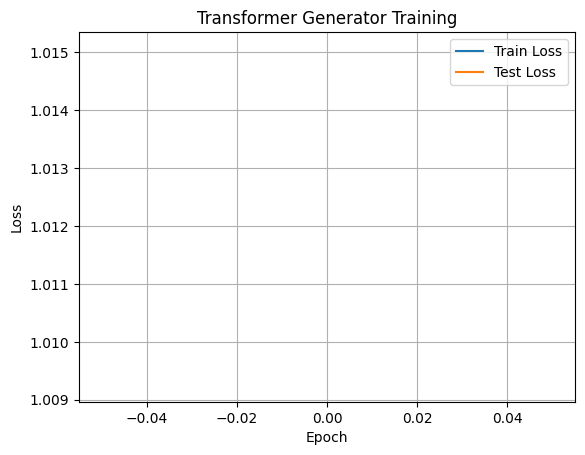

In [5]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Transformer Generator Training")
plt.grid(True)
plt.show()

### Visualize Reconstructions

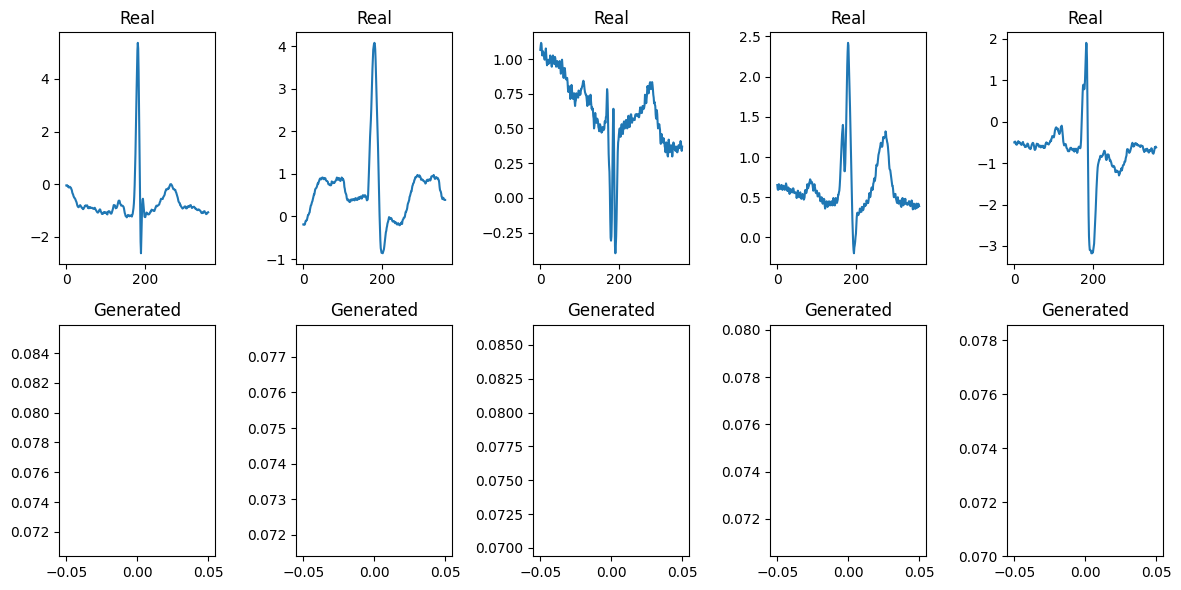

In [6]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

with torch.no_grad():
    batch = next(iter(test_loader)).to(device)
    batch = batch.permute(0, 2, 1)
    noise = torch.randn_like(batch)
    recon = model(noise).squeeze(2).cpu().numpy()
    target = batch.squeeze(2).cpu().numpy()

# Plot a few reconstructions
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.plot(target[i], label="Real")
    plt.title("Real")
    plt.subplot(2, 5, i+6)
    plt.plot(recon[i], label="Generated", color='orange')
    plt.title("Generated")
plt.tight_layout()
plt.show()

### Generate New Synthetic Beats

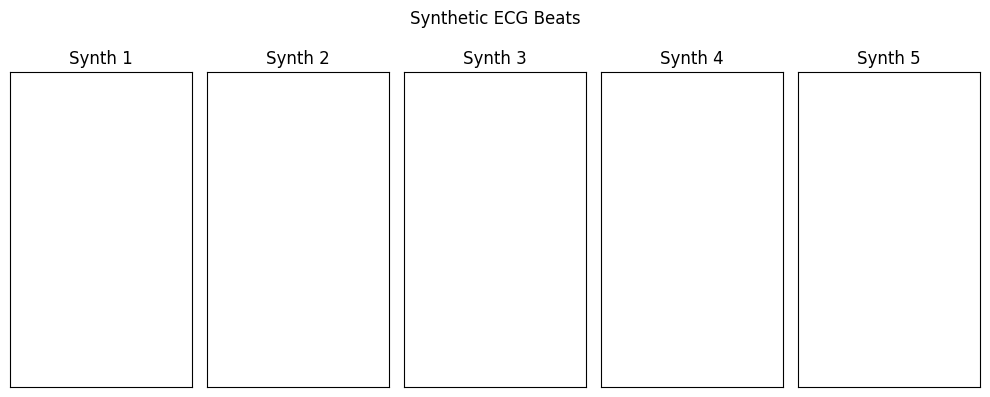

In [8]:
model.eval()
with torch.no_grad():
    z = torch.randn(5, 360, 1).to(device)
    generated_beats = model(z).squeeze(2).cpu().numpy()

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(generated_beats[i])
    plt.title(f"Synth {i+1}")
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Synthetic ECG Beats")
plt.tight_layout()
plt.show()